In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [42]:
oil_cpi = pd.read_csv('data/merge_oil_cpi/merge_oil_cpi_daily.csv')
price = pd.read_csv('data/price/price_baechoo.csv')
transaction = pd.read_csv('data/transaction_supply/transaction_supply_baechoo.csv')

oil_cpi.rename(columns={oil_cpi.columns[0] : "거래년월일"}, inplace=True)
price.rename(columns={price.columns[0] : "거래년월일"}, inplace=True)

merge = pd.merge(oil_cpi, price, on='거래년월일', how='outer')
merge = pd.merge(merge, transaction, on='거래년월일', how='outer')
# merge 의 2022-12월 데이터 삭제
merge = merge[merge['거래년월일'] < '2022-12-01']

merge = merge.fillna(method='ffill')
merge = merge.fillna(method='bfill')

merge.set_index("거래년월일",inplace=True)

In [43]:
merge

,자동차용 경유 가격 (원),전월비(%),평균,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0
...,...,...,...,...
2022-11-26,1879.15,-8.0,6100.0,296250.0
2022-11-27,1879.15,-8.0,6100.0,296250.0
2022-11-28,1879.15,-8.0,5664.0,201478.0


In [54]:
price= pd.read_csv('data/price/price_baechoo.csv')
price["구분"] = pd.to_datetime(price["구분"],format="%Y-%m-%d")
price_train= price[price["구분"] < '2022-12-01']
price_train

,구분,평균
0,2000-01-03,5600.0
1,2000-01-04,5600.0
2,2000-01-05,5620.0
3,2000-01-06,5700.0
4,2000-01-07,5670.0
...,...,...
5877,2022-11-24,6100.0
5878,2022-11-25,6100.0
5879,2022-11-28,5664.0
5880,2022-11-29,5592.0


In [60]:
price_test= price[price["구분"] >= '2022-12-01']
price_test

,구분,평균
47,2029-02-01,7430.0
2252,2029-02-01,4110.0
3254,2029-02-01,6600.0
4219,2029-02-01,9400.0
5882,2022-12-01,5462.0
5883,2022-12-05,5982.0
5884,2022-12-06,5502.0
5885,2022-12-07,5488.0
5886,2022-12-08,5408.0
5887,2022-12-09,5408.0


In [26]:
feature_cols= ['자동차용 경유 가격 (원)', '전월비(%)', '거래량']
label_col= ['평균']

X= merge[feature_cols]
y= merge[label_col]

scaler= MinMaxScaler()
merge[feature_cols]= scaler.fit_transform(X)
merge


,자동차용 경유 가격 (원),전월비(%),평균,거래량
거래년월일,,,,
2000-01-01,0.022324,0.540453,5600.0,0.028243
2000-01-02,0.022324,0.540453,5600.0,0.028243
2000-01-03,0.022324,0.540453,5600.0,0.028243
2000-01-04,0.022324,0.540453,5600.0,0.197620
2000-01-05,0.022324,0.540453,5620.0,0.094077
...,...,...,...,...
2022-11-26,0.863720,0.152104,6100.0,0.081833
2022-11-27,0.863720,0.152104,6100.0,0.081833
2022-11-28,0.863720,0.152104,5664.0,0.055649


In [27]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = merge[:-TEST_SIZE]
test = merge[-TEST_SIZE:]

In [30]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [31]:
from sklearn.model_selection import train_test_split

train_feature= train[feature_cols]
train_label= train[label_col]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((6520, 20, 3), (1630, 20, 3))

In [33]:
test_feature = test[feature_cols]
test_label = test[label_col]

test_feature.shape, test_label.shape

((200, 3), (200, 1))

In [34]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 3), (180, 1))

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [37]:
! pip install h5py

In [10]:
from sklearn.model_selection import train_test_split

feature_cols= ['자동차용 경유 가격 (원)', '전월비(%)', '거래량']
label_col= ['평균']

X= df[feature_cols]
y= df[label_col]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [13]:
model = Sequential()
model.add(LSTM(16, 
               input_shape=(X_train.shape[1], 1), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=150, verbose=0)

In [17]:
pred= model.predict(X_test)

In [51]:
import pandas as pd

df= pd.read_csv("data/merge_all/merge_all.csv")
df

,거래년월일,자동차용 경유 가격 (원),전월비(%),평균,거래량
0,2000-01-01,583.35,4.0,5600.0,102285.0
1,2000-01-02,583.35,4.0,5600.0,102285.0
2,2000-01-03,583.35,4.0,5600.0,102285.0
3,2000-01-04,583.35,4.0,5600.0,715338.0
4,2000-01-05,583.35,4.0,5620.0,340568.0
...,...,...,...,...,...
8365,2022-11-26,1879.15,-8.0,6100.0,296250.0
8366,2022-11-27,1879.15,-8.0,6100.0,296250.0
8367,2022-11-28,1879.15,-8.0,5664.0,201478.0
8368,2022-11-29,1879.15,-8.0,5592.0,77130.0


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
scale_cols = ['자동차용 경유 가격 (원)', '전월비(%)', '평균', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

      자동차용 경유 가격 (원)    전월비(%)        평균       거래량
0           0.022324  0.540453  0.106796  0.028243
1           0.022324  0.540453  0.106796  0.028243
2           0.022324  0.540453  0.106796  0.028243
3           0.022324  0.540453  0.106796  0.197620
4           0.022324  0.540453  0.107351  0.094077
...              ...       ...       ...       ...
8365        0.863720  0.152104  0.120666  0.081833
8366        0.863720  0.152104  0.120666  0.081833
8367        0.863720  0.152104  0.108571  0.055649
8368        0.863720  0.152104  0.106574  0.021293
8369        0.863720  0.152104  0.096865  0.033078

[8370 rows x 4 columns]


In [40]:
TEST_SIZE= 28

train= df_scaled[:-TEST_SIZE]
test= df_scaled[-TEST_SIZE:]

In [41]:
import numpy as np

In [42]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [43]:
feature_cols = ['자동차용 경유 가격 (원)', '전월비(%)', '거래량']
label_cols = ['평균']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

((6657, 20, 3), (1665, 20, 3))

In [44]:
# test dataset (실제 예측 해볼 데이터)
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((8, 20, 3), (8, 1))

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
from keras.models import load_model

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model.fit(x_train, y_train, epochs=200, batch_size=16, verbose=1, validation_data=(x_valid, y_valid), callbacks=[early_stop])

Epoch 1/200
417/417 [==============================] - 5s 7ms/step - loss: 0.0160 - val_loss: 0.0081
Epoch 2/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0101 - val_loss: 0.0079
Epoch 3/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 4/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 5/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 6/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0108
Epoch 7/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 8/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0078
Epoch 9/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0097 - val_loss: 0.0080
Epoch 10/200
417/417 [==============================] - 2s 5ms/step - loss: 0.0096 - val_lo

In [47]:
# 예측
pred = model.predict(test_feature)

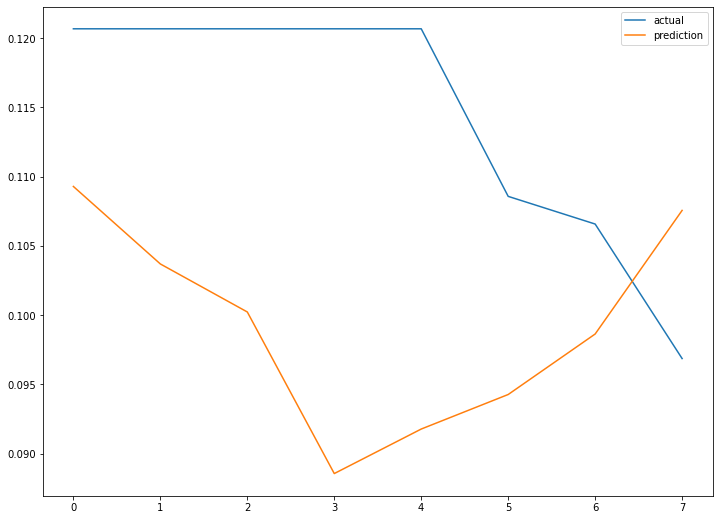

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import r2_score

test_score= r2_score(test_label, pred)
print(test_score)

-34.46038658166681


In [56]:
df_new= df.set_index('거래년월일')
df_new

,자동차용 경유 가격 (원),전월비(%),평균,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0
...,...,...,...,...
2022-11-26,1879.15,-8.0,6100.0,296250.0
2022-11-27,1879.15,-8.0,6100.0,296250.0
2022-11-28,1879.15,-8.0,5664.0,201478.0


In [103]:
df_new2= pd.read_csv('data/price/price_baechoo.csv')
df_new2= df_new2.set_index('구분')
df_new2

,평균
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [64]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler= MinMaxScaler()
scaler1= MinMaxScaler()

feature= df_new[['자동차용 경유 가격 (원)', '전월비(%)', '거래량']]
target= df_new[['평균']]

feature_fit= scaler.fit(feature)
feature_sc= feature_fit.transform(feature)

target_fit= scaler1.fit(target)
target_sc= target_fit.transform(target)

In [85]:
X=feature.values.tolist()
y=feature.values.tolist()

window_size = 7

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[1879.15, -8.0, 909340.0], [1879.15, -8.0, 714993.0], [1879.15, -8.0, 1079776.0], [1879.15, -8.0, 296250.0], [1879.15, -8.0, 296250.0], [1879.15, -8.0, 201478.0], [1879.15, -8.0, 77130.0]] -> [5242.0]


In [128]:
df_new2_copy= df_new2[df_new2.index < '2022-12-01']
df_new2_copy

,평균
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-11-24,6100.0
2022-11-25,6100.0
2022-11-28,5664.0


In [129]:
pr= df_new2_copy.values.tolist()

window_size= 6

pr_X = []
pr_y = []
for i in range(len(pr) - window_size):
    _X = pr[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = pr[i + window_size]     # 다음 날 종가
    pr_X.append(_X)
    pr_y.append(_y)
print(_X, "->", _y)

[[6260.0], [6100.0], [6100.0], [6100.0], [5664.0], [5592.0]] -> [5242.0]


In [87]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (5854, 7, 3) (5854, 1)
테스트 데이터의 크기 : (2509, 7, 3) (2509, 1)


In [130]:
X_tr, X_te, y_tr, y_te = train_test_split(pr_X, pr_y, test_size=0.2, random_state=0)

In [88]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', input_shape=(7, 3)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [118]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model.fit(train_X, train_y, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
196/196 [==============================] - 3s 4ms/step - loss: 34282010624.0000
Epoch 2/70
196/196 [==============================] - 1s 4ms/step - loss: 5845220352.0000
Epoch 3/70
196/196 [==============================] - 1s 4ms/step - loss: 845463104.0000
Epoch 4/70
196/196 [==============================] - 1s 4ms/step - loss: 779369536.0000
Epoch 5/70
196/196 [==============================] - 1s 4ms/step - loss: 639168640.0000
Epoch 6/70
196/196 [==============================] - 1s 4ms/step - loss: 376537120.0000
Epoch 7/70
196/196 [==============================] - 1s 4ms/step - loss: 270749632.0000
Epoch 8/70
196/196 [==============================] - 1s 3ms/step - loss: 238332528.0000
Epoch 9/70
196/196 [==============================] - 1s 3ms/step - loss: 259020656.0000
Epoch 10/70
 30/196 [===>..........................] - ETA: 0s - loss: 237694016.0000

KeyboardInterrupt: 

In [131]:
model2 = Sequential()
model2.add(LSTM(units=20, activation='relu', input_shape=(6, 1)))
model2.add(Dense(units=1))
model2.compile(optimizer='adam', loss='mean_squared_error')

In [132]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model2.fit(X_tr, y_tr, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
157/157 [==============================] - 4s 2ms/step - loss: 78689040.0000
Epoch 2/70
157/157 [==============================] - 0s 2ms/step - loss: 1646409.1250
Epoch 3/70
157/157 [==============================] - 0s 2ms/step - loss: 911679.5000
Epoch 4/70
157/157 [==============================] - 0s 2ms/step - loss: 754652.6250
Epoch 5/70
157/157 [==============================] - 0s 3ms/step - loss: 692939.0625
Epoch 6/70
157/157 [==============================] - 1s 3ms/step - loss: 859311.4375: 0s - loss: 
Epoch 7/70
157/157 [==============================] - 0s 3ms/step - loss: 637449.3750
Epoch 8/70
157/157 [==============================] - 0s 3ms/step - loss: 725954.7500
Epoch 9/70
157/157 [==============================] - 1s 3ms/step - loss: 1376395.3750
Epoch 10/70
157/157 [==============================] - 0s 3ms/step - loss: 790330.6875
Epoch 11/70
157/157 [==============================] - 0s 3ms/step - loss: 943324.3750
Epoch 12/70
157/157 [==============

In [133]:
pred_y = model2.predict(X_te)

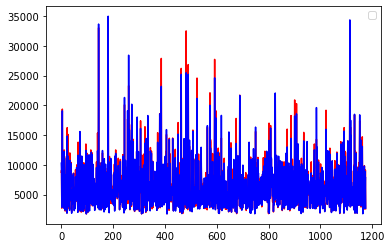

In [134]:
plt.figure()
plt.plot(y_te, color='red')
plt.plot(pred_y, color='blue')
plt.legend()
plt.show()

In [135]:
from sklearn.metrics import r2_score

test_score= r2_score(y_te, pred_y)
print(test_score)

0.9604748109410501


In [141]:
df_new2_test= df_new2[df_new2.index >= '2022-12-01']

In [142]:
df_new2_test

,평균
구분,
2022-12-01,5462.0
2022-12-05,5982.0
2022-12-06,5502.0
2022-12-07,5488.0
2022-12-08,5408.0
2022-12-09,5408.0
2022-12-12,5244.5
2022-12-13,5245.5
2022-12-14,5430.5


In [144]:
#12월 1일 ~ 12월 20일

pr_test= df_new2_test.values.tolist()

window_size= 6

pr_X_test = []
pr_y_test = []
for i in range(len(pr_test) - window_size):
    _X = pr_test[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = pr_test[i + window_size]     # 다음 날 종가
    pr_X_test.append(_X)
    pr_y_test.append(_y)
print(_X, "->", _y)


[[5244.5], [5245.5], [5430.5], [5430.5], [5304.0], [5459.5]] -> [5764.0]


In [146]:
pr_test_X= np.array(pr_X_test)
pr_test_y= np.array(pr_y_test)

pr_test_X.shape, pr_test_y.shape

((7, 6, 1), (7, 1))

In [147]:
pred_pr_y= model2.predict(pr_test_X)

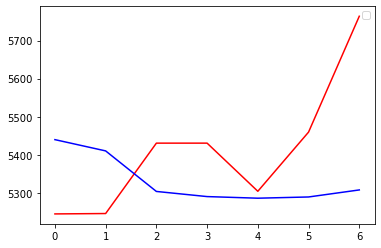

In [148]:
plt.figure()
plt.plot(pr_test_y, color='red')
plt.plot(pred_pr_y, color='blue')
plt.legend()
plt.show()

In [249]:
for i in range(len(pr_test_y)):
    print((pr_test_y[i]-pred_pr_y[i])/pr_test_y[i]*100)

[-3.72210992]
[-3.1379203]
[2.33740203]
[2.5861238]
[0.3429292]
[3.12248682]
[7.91922893]


In [150]:
pred_pr_y

array([[5439.706 ],
       [5410.0996],
       [5303.5674],
       [5290.0605],
       [5285.811 ],
       [5289.028 ],
       [5307.5356]], dtype=float32)

In [149]:
test_score= r2_score(pr_test_y, pred_pr_y)
print(test_score)

-0.7437706611272257


In [ ]:
feature_pd= pd.DataFrame(feature_sc, columns=['자동차용 경유 가격 (원)', '전월비(%)', '거래량'])
target_pd= pd.DataFrame(target_sc, columns=['평균'])

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(feature_pd, target_pd, random_state=0, test_size=0.2)

In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(7, 4)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [250]:
df= pd.read_csv('data/price/price_baechoo.csv')
df

,구분,평균
0,2000-01-03,5600.0
1,2000-01-04,5600.0
2,2000-01-05,5620.0
3,2000-01-06,5700.0
4,2000-01-07,5670.0
...,...,...
5890,2022-12-14,5430.5
5891,2022-12-15,5430.5
5892,2022-12-16,5304.0
5893,2022-12-19,5459.5


In [281]:
num_list= []
for i in range(1,1179):
    num_list.append(i*3)

open=[]
high=[]
low= []
close= []
for i in range(len(num_list)):
    if i==0:
        test_df= df.iloc[0:num_list[i]]
    else:
        test_df= df.iloc[num_list[i-1]:num_list[i]]
    open.append(test_df.iloc[0]['평균'])
    max= test_df.iloc[0]['평균']
    min= test_df.iloc[0]['평균']
    for i in range(len(test_df)):
        if test_df.iloc[i]['평균'] > max:
            max= test_df.iloc[i]['평균']
        if test_df.iloc[i]['평균'] < min:
            min= test_df.iloc[i]['평균']
    high.append(max)
    low.append(min)
    close.append(test_df.iloc[len(test_df)-1]['평균'])

In [282]:
candle_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가'])
candle_df['시가']= open
candle_df['고가']= high
candle_df['저가']= low
candle_df['종가']= close
candle_df

,시가,고가,저가,종가
0,5600.0,5620.0,5600.0,5620.0
1,5700.0,5770.0,5670.0,5770.0
2,5790.0,5790.0,5630.0,5630.0
3,5630.0,5630.0,5630.0,5630.0
4,5630.0,5650.0,5630.0,5650.0
...,...,...,...,...
1173,11600.0,11600.0,11400.0,11400.0
1174,11300.0,11300.0,11100.0,11100.0
1175,11700.0,11700.0,11300.0,11300.0
1176,11300.0,11300.0,11300.0,11300.0


In [283]:
from sklearn.preprocessing import StandardScaler

X= candle_df[['시가', '고가', '저가']]
y= candle_df[['종가']]

scaler= StandardScaler()
scaler1= StandardScaler()

X_sc= scaler.fit_transform(X)
y_sc= scaler1.fit_transform(y)

In [284]:
window_size = 2

data_X = []
data_y = []
for i in range(len(y_sc) - window_size):
    _X = X_sc[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y_sc[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[1.90404825 1.77699273 1.88425143]
 [1.77875147 1.6567051  1.88425143]] -> [1.74931111]


In [285]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (823, 2, 3) (823, 1)
테스트 데이터의 크기 : (353, 2, 3) (353, 1)


In [286]:
model_test = Sequential()
model_test.add(LSTM(units=20, activation='relu', input_shape=(2, 3)))
model_test.add(Dense(units=1))
model_test.compile(optimizer='adam', loss='mean_squared_error')

In [287]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model_test.fit(train_X, train_y, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
28/28 [==============================] - 4s 5ms/step - loss: 0.4902
Epoch 2/70
28/28 [==============================] - 0s 3ms/step - loss: 0.2945
Epoch 3/70
28/28 [==============================] - 0s 3ms/step - loss: 0.1239
Epoch 4/70
28/28 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 5/70
28/28 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 6/70
28/28 [==============================] - 0s 4ms/step - loss: 0.0491
Epoch 7/70
28/28 [==============================] - 0s 4ms/step - loss: 0.0481
Epoch 8/70
28/28 [==============================] - 0s 7ms/step - loss: 0.0472
Epoch 9/70
28/28 [==============================] - 0s 4ms/step - loss: 0.0463
Epoch 10/70
28/28 [==============================] - 0s 3ms/step - loss: 0.0455
Epoch 11/70
28/28 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 12/70
28/28 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 13/70
28/28 [==============================

In [289]:
pred_y = model_test.predict(test_X)

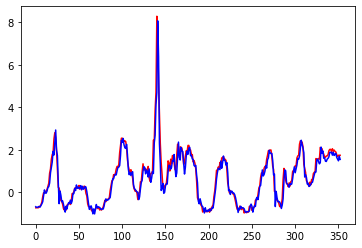

In [291]:
plt.figure()
plt.plot(test_y, color='red')
plt.plot(pred_y, color='blue')
plt.show()

In [292]:
test_score= r2_score(test_y, pred_y)
print(test_score)

0.9126503221964022


In [335]:
num_list= []
for i in range(1900, 1965):
    num_list.append(i*3)

open=[]
high=[]
low= []
close= []
for i in range(len(num_list)):
    if i == 0:
        test_df= df.iloc[3534:num_list[0]]
    else:
        test_df= df.iloc[num_list[i-1]:num_list[i]]
    open.append(test_df.iloc[0]['평균'])
    max= test_df.iloc[0]['평균']
    min= test_df.iloc[0]['평균']
    for i in range(len(test_df)):
        if test_df.iloc[i]['평균'] > max:
            max= test_df.iloc[i]['평균']
        if test_df.iloc[i]['평균'] < min:
            min= test_df.iloc[i]['평균']
    high.append(max)
    low.append(min)
    close.append(test_df.iloc[len(test_df)-1]['평균'])

In [336]:
df_test= pd.DataFrame(columns=['시가', '고가', '저가', '종가'])
df_test['시가']= open
df_test['고가']= high
df_test['저가']= low
df_test['종가']= close
df_test

,시가,고가,저가,종가
0,10700.0,27880.0,2600.0,8644.0
1,9016.0,9312.0,9016.0,9312.0
2,9117.0,9492.0,9117.0,9492.0
3,9532.0,10220.0,9532.0,10220.0
4,9785.0,9865.0,9785.0,9845.0
...,...,...,...,...
60,6100.0,6100.0,5664.0,5664.0
61,5592.0,5592.0,5242.0,5462.0
62,5982.0,5982.0,5488.0,5488.0
63,5408.0,5408.0,5244.5,5244.5


In [338]:
f_test_X= df_test[['시가', '고가', '저가']]
f_test_y= df_test[['종가']]

f_test_X_sc= scaler.fit_transform(f_test_X)
f_test_y_sc= scaler1.fit_transform(f_test_y)

In [339]:
window_size = 2

data_X = []
data_y = []
for i in range(len(f_test_y_sc) - window_size):
    _X = f_test_X_sc[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = f_test_y_sc[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[-0.96749181 -0.99539578 -0.99256208]
 [-1.04152587 -1.06457495 -1.0261188 ]] -> [-1.02517334]


In [340]:
check_X = np.array(data_X)
check_y = np.array(data_y)

In [341]:
pred_check_y= model_test.predict(check_X)

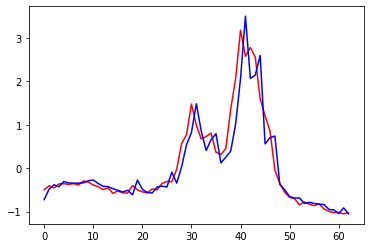

In [342]:
plt.figure()
plt.plot(check_y, color='red')
plt.plot(pred_check_y, color='blue')
plt.show()

In [343]:
test_score= r2_score(check_y, pred_check_y)
print(test_score)

0.8635843284397078


In [344]:
y_pred=scaler1.inverse_transform(pred_check_y)

#  예측값을 데이터프레임에 저장한다
df_pred = pd.DataFrame(y_pred, columns=['예측 가격'])

df_pred

,예측 가격
0,7747.899414
1,9610.511719
2,10389.019531
3,10045.937500
4,10973.438477
...,...
58,6012.389160
59,5932.655762
60,5286.396973
61,6290.579590


In [345]:
y_actual= scaler1.inverse_transform(check_y)

df_pred['실제 가격']= y_actual

df_pred

,예측 가격,실제 가격
0,7747.899414,9492.0
1,9610.511719,10220.0
2,10389.019531,9845.0
3,10045.937500,10540.0
4,10973.438477,10580.0
...,...,...
58,6012.389160,5664.0
59,5932.655762,5462.0
60,5286.396973,5488.0
61,6290.579590,5244.5


In [346]:
df_pred['차이']= (df_pred['실제 가격']-df_pred['예측 가격']) / df_pred['실제 가격'] * 100
df_pred

,예측 가격,실제 가격,차이
0,7747.899414,9492.0,18.374427
1,9610.511719,10220.0,5.963682
2,10389.019531,9845.0,-5.525846
3,10045.937500,10540.0,4.687500
4,10973.438477,10580.0,-3.718700
...,...,...,...
58,6012.389160,5664.0,-6.150939
59,5932.655762,5462.0,-8.616913
60,5286.396973,5488.0,3.673525
61,6290.579590,5244.5,-19.946222


In [330]:
df_pred['차이'].median()

-1.3326927063957092

c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\l

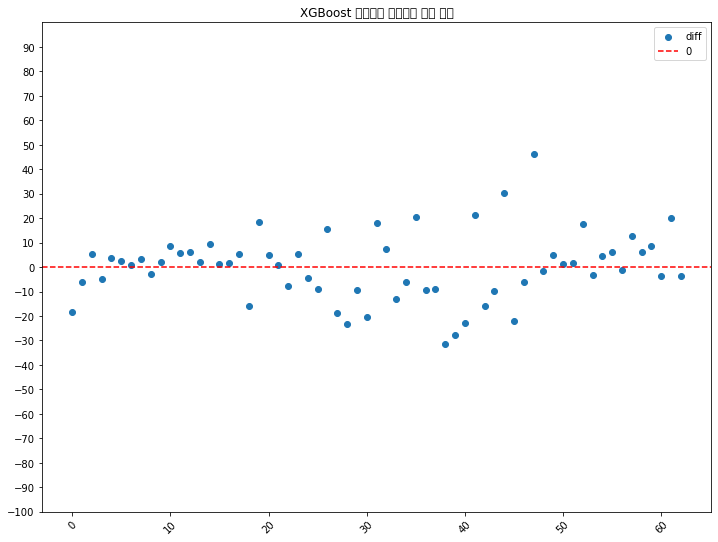

In [349]:
diff = (df_pred['예측 가격'] - df_pred['실제 가격']) / df_pred['실제 가격'] * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.scatter(df_pred.index, diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()


In [214]:
bar= []
for i in range(1, len(df['구분'])):
    if (df['구분'][i]-df['구분'][i-1]).days != 1:
        bar.append(df.index[i]) 

In [227]:
open= []
high= []
low= []
close= []

for i in range(len(bar)):
    if i==0:
        test_df= df.iloc[0:bar[0]]
    else:
        test_df= df.iloc[bar[i-1]:bar[i]]
    open.append(test_df.iloc[0]['평균'])
    max= test_df.iloc[0]['평균']
    min= test_df.iloc[0]['평균']
    for i in range(len(test_df)):
        if test_df.iloc[i]['평균'] > max:
            max= test_df.iloc[i]['평균']
        if test_df.iloc[i]['평균'] < min:
            min= test_df.iloc[i]['평균']
    high.append(max)
    low.append(min)
    close.append(test_df.iloc[len(test_df)-1]['평균'])

In [231]:
candle_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가'])
candle_df['시가']= open
candle_df['고가']= high
candle_df['저가']= low
candle_df['종가']= close
candle_df

,시가,고가,저가,종가
0,5600.0,5770.0,5600.0,5770.0
1,5790.0,5790.0,5630.0,5630.0
2,5630.0,5850.0,5630.0,5850.0
3,5890.0,6450.0,5890.0,6450.0
4,6620.0,6830.0,6620.0,6830.0
...,...,...,...,...
1317,6724.0,7018.0,6432.0,7018.0
1318,6300.0,6300.0,6100.0,6100.0
1319,5664.0,5664.0,5242.0,5462.0
1320,5982.0,5982.0,5408.0,5408.0


In [235]:
from sklearn.preprocessing import StandardScaler

X= candle_df[['시가', '고가', '저가']]
y= candle_df[['종가']]

scaler= StandardScaler()

X_sc= scaler.fit_transform(X)
y_sc= scaler.fit_transform(y)

In [ ]:
train_size = int(len(X_sc) * 0.8)
train_X = np.array(X_sc[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

In [ ]:
# 예측값 성능 평가
# 예측값과 실제값의 차이를 비율로 계산한다
diff = (y_pred - y_test) / y_test * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()
